<a href="https://colab.research.google.com/github/ajk251/CS5200-Project/blob/main/TensorFlow%20Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/tutorials/generative/style_transfer

In [146]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools


In [147]:
def tensor_to_image(tensor):
  
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]

  return PIL.Image.fromarray(tensor)


def load_img(path_to_img):

  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]

  return img


def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


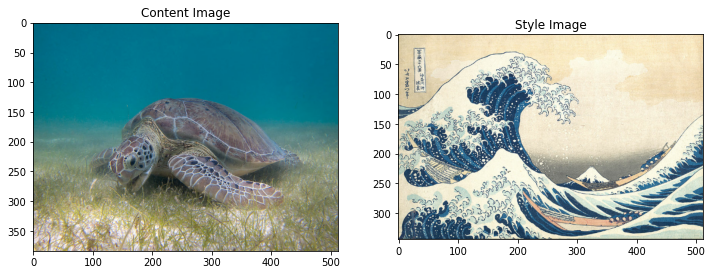

In [148]:

# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

# content_path = tf.keras.utils.get_file('1024px-Old_house_typical_of_the_island_of_Margarita.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Old_house_typical_of_the_island_of_Margarita.jpg/1024px-Old_house_typical_of_the_island_of_Margarita.jpg')
# style_path = tf.keras.utils.get_file('6ad8f7d6-c8a9-5216-2664-09bd5691c6ed.jpg','https://www.artic.edu/iiif/2/6ad8f7d6-c8a9-5216-2664-09bd5691c6ed/full/843,/0/default.jpg')

# content_path = tf.keras.utils.get_file('Chicago Union Station 1943.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Chicago_Union_Station_1943.jpg/600px-Chicago_Union_Station_1943.jpg')
# style_path = tf.keras.utils.get_file('6ad8f7d6-c8a9-5216-2664-09bd5691c6ed.jpg','https://www.artic.edu/iiif/2/6ad8f7d6-c8a9-5216-2664-09bd5691c6ed/full/843,/0/default.jpg')

# content_path = tf.keras.utils.get_file('800px-Betsy_DeVos_official_portrait.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Betsy_DeVos_official_portrait.jpg/800px-Betsy_DeVos_official_portrait.jpg')
# style_path = tf.keras.utils.get_file('800px-Quentin_Matsys_-_A_Grotesque_old_woman.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Quentin_Matsys_-_A_Grotesque_old_woman.jpg/800px-Quentin_Matsys_-_A_Grotesque_old_woman.jpg')

# content_path = tf.keras.utils.get_file('American_Gothic_Dress-Up.jpg', 'https://upload.wikimedia.org/wikipedia/commons/b/bb/American_Gothic_Dress-Up.jpg')
# style_path = tf.keras.utils.get_file('Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg/497px-Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg')

# content_path = tf.keras.utils.get_file('800px-Paradise_shelduck_portrait,_New_Zealand.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Paradise_shelduck_portrait%2C_New_Zealand.jpg/800px-Paradise_shelduck_portrait%2C_New_Zealand.jpg')
# style_path = tf.keras.utils.get_file('800px-Red-billed_gull_portrait,_New_Brighton,_New_Zealand_03','https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Red-billed_gull_portrait%2C_New_Brighton%2C_New_Zealand_03.jpg/800px-Red-billed_gull_portrait%2C_New_Brighton%2C_New_Zealand_03.jpg')

# style_path = tf.keras.utils.get_file('Agamemnon"_-_107_GAÏTIS.jpg','https://upload.wikimedia.org/wikipedia/commons/8/8f/%22Agamemnon%22_-_107_GA%C3%8FTIS.jpg')

content_path = tf.keras.utils.get_file('800px-Green_Sea_Turtle_grazing_seagrass.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg/800px-Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = tf.keras.utils.get_file('Tsunami_by_hokusai_19th_century.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/800px-Tsunami_by_hokusai_19th_century.jpg')

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


In [149]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))

vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [150]:

# predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
# [(class_name, prob) for (number, class_name, prob) in predicted_top_5]


In [151]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# print()
# for layer in vgg.layers:
  # print(layer.name)


# Building the model

In [152]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [153]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

class StyleContentModel(tf.keras.models.Model):

  def __init__(self, style_layers, content_layers):

    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}


In [154]:
def gram_matrix(input_tensor):

  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  
  return result/(num_locations)


In [155]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()


block1_conv1
  shape:  (1, 344, 512, 64)
  min:  0.0
  max:  828.4032
  mean:  37.497013

block2_conv1
  shape:  (1, 172, 256, 128)
  min:  0.0
  max:  4266.2085
  mean:  224.6604

block3_conv1
  shape:  (1, 86, 128, 256)
  min:  0.0
  max:  9687.25
  mean:  201.91708

block4_conv1
  shape:  (1, 43, 64, 512)
  min:  0.0
  max:  22257.996
  mean:  766.33514

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  2940.568
  mean:  56.42083



In [156]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.047952097
    max:  26744.818
    mean:  792.3755

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  96737.23
    mean:  12158.113

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  309293.38
    mean:  8025.507

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3486380.0
    mean:  116746.46

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  80423.625
    mean:  750.4751

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  926.17224
    mean:  9.665634


In [157]:
def style_content_loss(outputs):

    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss

    print(loss)

    return loss

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


In [158]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4


In [159]:
@tf.function()
def train_step(image):
  
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)


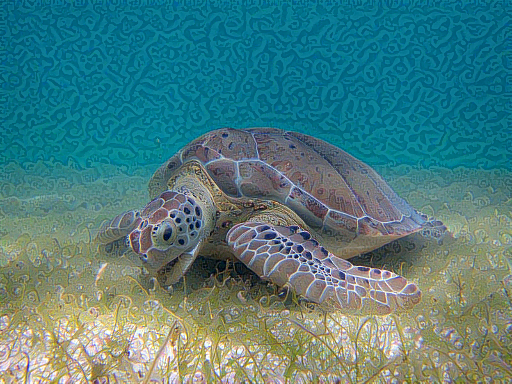

In [160]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

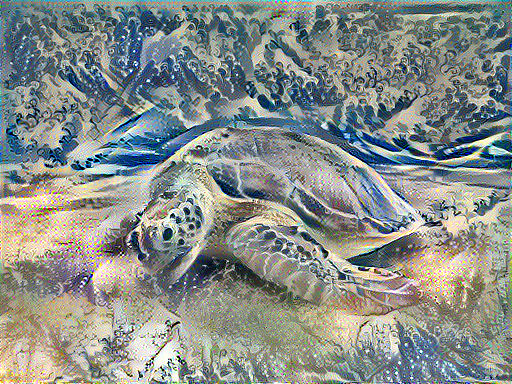

Train step: 1000
Total time: 34.3


In [161]:
import time

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


In [166]:
filename = 'image11.png'
tensor_to_image(image).save(filename)

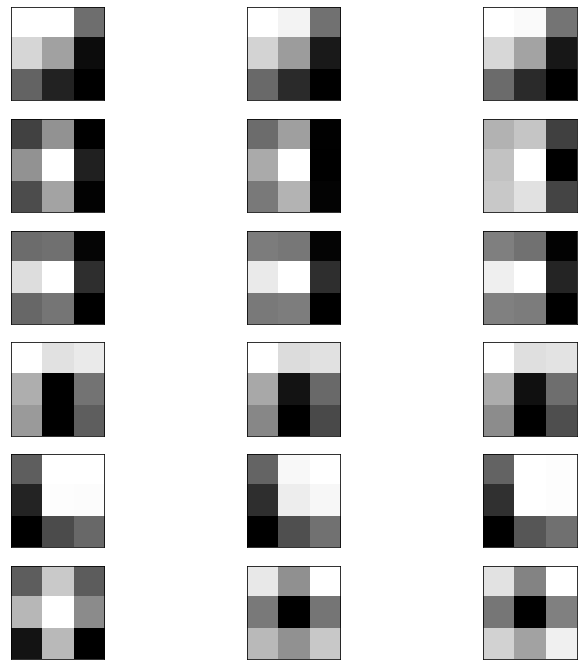

In [163]:
# Adapted from:
#   https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

filters, biases = vgg.layers[1].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 6,1

for i in range(n_filters):
  f = filters[:,:,:,i]
  for j in range(3):

    ax = plt.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:,:,j], cmap='gray')
    ix += 1

plt.show()


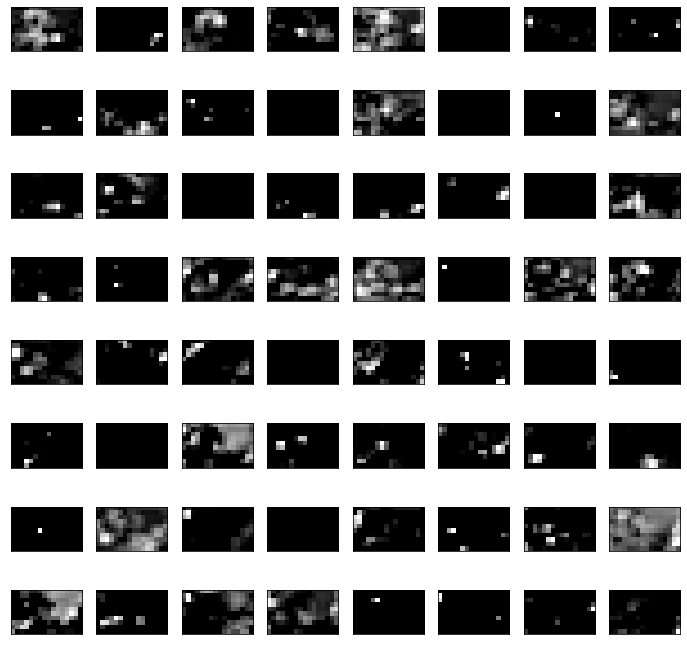

In [164]:
# Adapted from:
#   https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

feature_maps = vgg.predict(style_image)

square = 8
ix = 1

for _ in range(square):
  for _ in range(square):
    ax = plt.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1

plt.show()

(1, 10, 16, 512)